In [1]:
import sys

if "google.colab" in sys.modules:
    %pip install -q git+https://github.com/ott-jax/ott@main

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.3/172.3 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.2/175.2 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 4.1 MB/s eta 0:00:00


In [2]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from ott.geometry import pointcloud
from ott.solvers import linear

{mod}`ott` is built on top of {mod}`jax`, so we use {mod}`jax` to instantiate all variables. We generate two 2-dimensional random point clouds of $7$ and $11$ points, respectively, and store them in variables `x` and `y`:

In [5]:
rngs = jax.random.split(jax.random.PRNGKey(0), 2)
d, n_x, n_y = 2, 100, 100
x = jax.random.normal(rngs[0], (n_x, d))
y = jax.random.normal(rngs[1], (n_y, d)) + 0.5

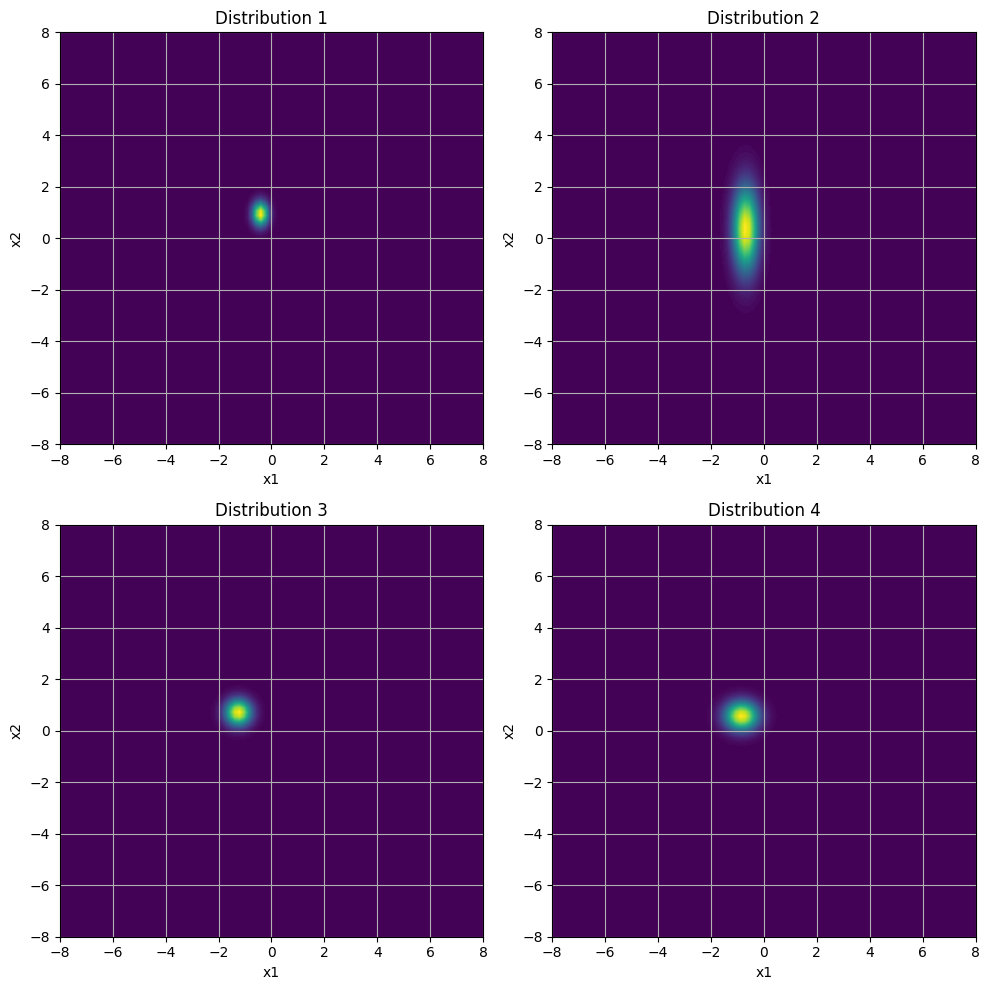

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def generate_distribution_params(d):
    a = np.random.randn(2, d)
    Q = np.random.randn(2, d, d)
    Q = np.array([np.dot(Q[i], Q[i].T) for i in range(2)])  # Ensure Q is symmetric positive definite
    return a, Q

def calculate_density(x, a, Q):
    q1 = np.sum((x - a[0])**2 @ Q[0], axis=1)
    q2 = np.sum((x - a[1])**2 @ Q[1], axis=1)
    density = np.exp(-q1 - q2)
    return density.reshape(100, 100)

def generate_mixture(d, K):
    distributions = []
    for _ in range(K):
        a, Q = generate_distribution_params(d)
        distributions.append((a, Q))

    return distributions

def plot_mixture(distributions):
    x, y = np.meshgrid(np.linspace(-8, 8, 100), np.linspace(-8, 8, 100))
    xy = np.column_stack([x.flat, y.flat])

    density = np.zeros_like(x)
    for a, Q in distributions:
        density += calculate_density(xy, a, Q)

    density /= len(distributions)  # Normalize by the number of distributions

    plt.figure(figsize=(8, 6))
    plt.contourf(x, y, density.reshape(x.shape), levels=100, cmap='viridis')
    plt.colorbar(label='Density')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Mixture of 2D Distributions')
    plt.grid(True)
    plt.show()

def plot_mixture(distributions):
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    for i, (a, Q) in enumerate(distributions):
        ax = axs[i // 2, i % 2]
        x, y = np.meshgrid(np.linspace(-8, 8, 100), np.linspace(-8, 8, 100))
        xy = np.column_stack([x.flat, y.flat])
        density = calculate_density(xy, a, Q)
        ax.contourf(x, y, density, levels=100, cmap='viridis')
        ax.set_xlabel('x1')
        ax.set_ylabel('x2')
        ax.set_title(f'Distribution {i+1}')
        ax.grid(True)
    plt.tight_layout()
    plt.show()

# Parameters
d = 2  # Dimensionality
K = 4 # Number of distributions in the mixture

# Generate mixture distributions
mixture_distributions = generate_mixture(d, K)

# Plot the mixture distributions in a 2x2 figure
plot_mixture(mixture_distributions)

In [34]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

@jax.jit
def generate_distribution_params(rng, d):
    a = jax.random.normal(rng, (2, d))
    Q = jax.random.normal(rng, (2, d, d))
    Q = jnp.array([jnp.dot(Q[i], Q[i].T) for i in range(2)])  # Ensure Q is symmetric positive definite
    return a, Q

def calculate_density(x, a, Q):
    q1 = jnp.sum((x - a[0])**2 @ Q[0], axis=1)
    q2 = jnp.sum((x - a[1])**2 @ Q[1], axis=1)
    density = jnp.exp(-q1 - q2)
    return density / jnp.sum(density)  # Normalize density



@jax.jit
def generate_mixture(rng, d, max_K):
    distributions = []
    for _ in range(5):  # Set a fixed range
        rng, subrng = jax.random.split(rng)
        K = jax.random.randint(subrng, (1,), 1, max_K)[0]  # Choose K randomly
        a, Q = generate_distribution_params(subrng, d)
        distributions.append((a, Q))

    return distributions

def plot_mixture(distributions):
    x, y = jnp.meshgrid(jnp.linspace(-8, 8, 100), jnp.linspace(-8, 8, 100))
    xy = jnp.column_stack([x.flatten(), y.flatten()])

    density = jnp.zeros_like(x)
    for a, Q in distributions:
        density += calculate_density(xy, a, Q)

    density /= len(distributions)  # Normalize by the number of distributions

    plt.figure(figsize=(8, 6))
    plt.contourf(x, y, density, levels=100, cmap='viridis')
    plt.colorbar(label='Density')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('Mixture of 2D Distributions')
    plt.grid(True)
    plt.show()

# Parameters
d = 2  # Dimensionality
key = jax.random.PRNGKey(0)
K = jax.random.randint(key, (1,), 1, 6)[0]  # Number of distributions in the mixture (uniformly chosen between 1 and 5)

# Generate mixture distributions
key, subkey = jax.random.split(key)
mixture_distributions = generate_mixture(subkey, d, K)

# Plot the mixture distribution
plot_mixture(mixture_distributions)


TypeError: Shapes must be 1D sequences of concrete values of integer type, got (2, Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=2/0)>).
If using `jit`, try using `static_argnums` or applying `jit` to smaller subfunctions.
The error occurred while tracing the function generate_distribution_params at <ipython-input-34-6ce48a352b16>:5 for jit. This concrete value was not available in Python because it depends on the value of the argument d.

Because these point clouds are 2-dimensional, we can use scatter plots to illustrate them.

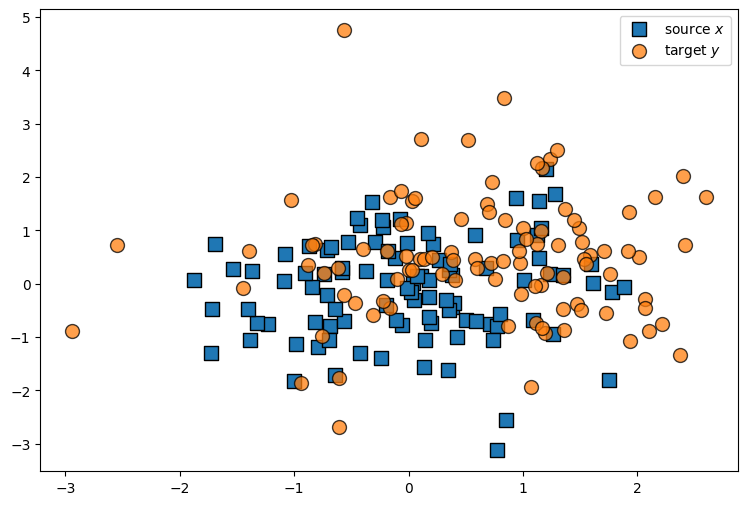

In [48]:
x_args = {"s": 100, "label": r"source $x$", "marker": "s", "edgecolor": "k"}
y_args = {"s": 100, "label": r"target $y$", "edgecolor": "k", "alpha": 0.75}
plt.figure(figsize=(9, 6))
plt.scatter(x[:, 0], x[:, 1], **x_args)
plt.scatter(y[:, 0], y[:, 1], **y_args)
plt.legend()
plt.show()

In [49]:
geom = pointcloud.PointCloud(x, y, cost_fn=None)

In [50]:
solve_fn = jax.jit(linear.solve)
ot = solve_fn(geom)

In [51]:
ot = solve_fn(geom)

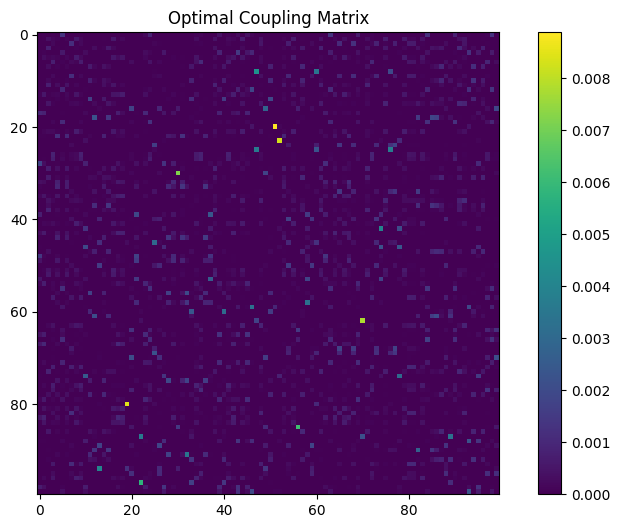

In [52]:
plt.figure(figsize=(10, 6))
plt.imshow(ot.matrix)
plt.colorbar()
plt.title("Optimal Coupling Matrix")
plt.show()

In [53]:
print(
    f"2-Wasserstein: Lower bound = {ot.dual_cost:3f}, upper = {ot.primal_cost:3f}"
)

2-Wasserstein: Lower bound = -0.478372, upper = 1.262157
